In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import splitfolders
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Building the model**

In [ ]:
def residual_block(x, filters):
    shortcut = x

    # First convolutional layer
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    #  the shortcut
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet18(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    for _ in range(2):  # Stage 1
        x = residual_block(x, 64)

    for _ in range(2):  # Stage 2
        x = residual_block(x, 128)

    for _ in range(2):  # Stage 3
        x = residual_block(x, 256)

    for _ in range(2):  # Stage 4
        x = residual_block(x, 512)

    # Final Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    return model

input_shape = (128, 128, 3)
model = build_resnet18(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 64, 64, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 32, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 11,191,425 (42.69 MB)

 Trainable params: 11,181,825 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

# **Augmenting the dataset**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Pneumonia dataset-Resnet/split_chest_xray/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/My Drive/Pneumonia dataset-Resnet/split_chest_xray/val',
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary"
)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/Pneumonia dataset-Resnet/split_chest_xray/test',
    target_size=(128, 128),
    batch_size=20,
    class_mode='binary',
    shuffle=False
)


Found 4089 images belonging to 2 classes.
Found 511 images belonging to 2 classes.
Found 512 images belonging to 2 classes.


# **Training the model**

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    batch_size=32,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 900s 6s/step - accuracy: 0.8423 - loss: 0.3600 - val_accuracy: 0.8376 - val_loss: 2.0165 - learning_rate: 0.0010
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 108s 569ms/step - accuracy: 0.8873 - loss: 0.2615 - val_accuracy: 0.8376 - val_loss: 0.9704 - learning_rate: 0.0010
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 83s 569ms/step - accuracy: 0.9045 - loss: 0.2352 - val_accuracy: 0.8669 - val_loss: 0.3424 - learning_rate: 0.0010
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 578ms/step - accuracy: 0.9075 - loss: 0.2176 - val_accuracy: 0.8376 - val_loss: 1.2576 - learning_rate: 0.0010
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 78s 574ms/step - accuracy: 0.9194 - loss: 0.2010 - val_accuracy: 0.1644 - val_loss: 8.8921 - learning_rate: 0.0010
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 76s 569ms/step - accuracy: 0.9169 - loss: 0.2026 - val_accuracy: 0.3855 - val_loss: 1.7725 - learning_rate: 0.0010
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 571ms/step - accuracy: 0.9203 - loss: 

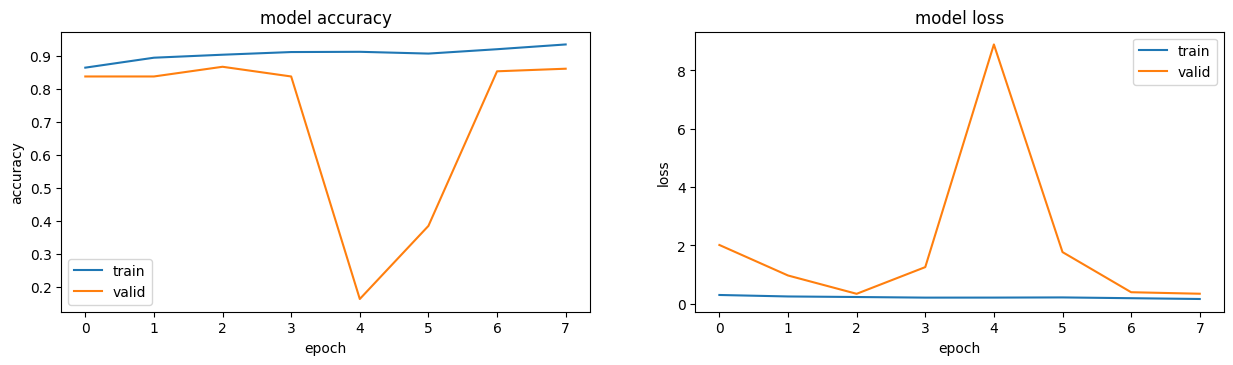

In [ ]:
plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

# **Evaluation and Predicition**

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator )
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 303s 12s/step - accuracy: 0.8560 - loss: 0.3554
Test Loss: 0.3367936611175537
Test Accuracy: 0.85546875


In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step


# **Classification report**

In [ ]:
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)


              precision    recall  f1-score   support

      NORMAL       0.54      0.86      0.66        84
   PNEUMONIA       0.97      0.86      0.91       428

    accuracy                           0.86       512
   macro avg       0.75      0.86      0.78       512
weighted avg       0.90      0.86      0.87       512



# **Confusion matrix**

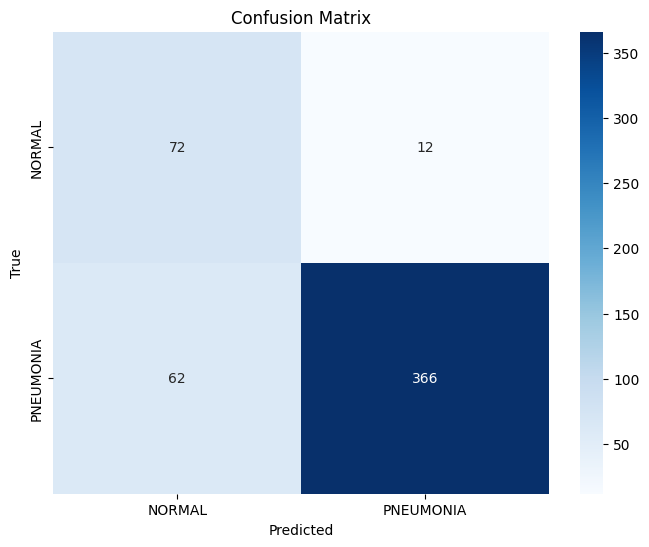

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# **AUC and ROC**

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc}")


AUC: 0.9210614152202937


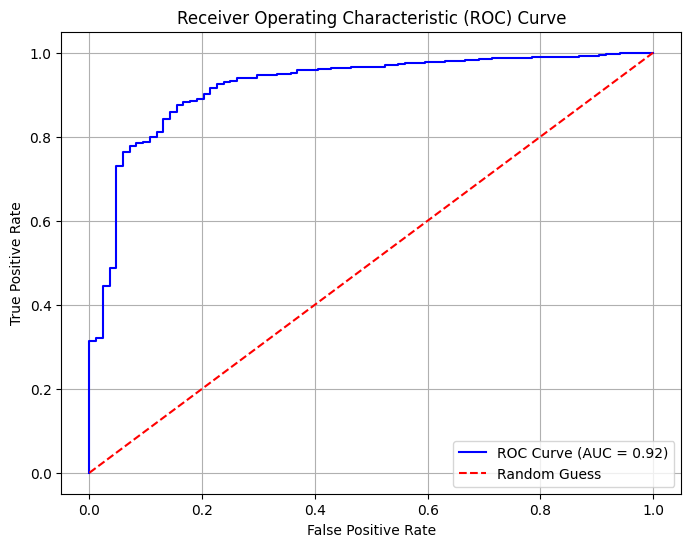

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
